In [52]:
import pandas as pd
import numpy as np
import re
import math
import random
import os

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d

%matplotlib inline
#%matplotlib notebook

In [53]:
import warnings
warnings.filterwarnings('ignore') #чтобы красные уведомления внизу ячеек не отсвечивали

In [54]:
np.random.seed(42) # если оставить, то при каждом перезапуске ноутбука результаты будут одинаковыми, если убрать - то разными

## Описание этапов ЛР

=============================================================
=============================================================

### 1. Read data <br>
Тут мы считываем и первично обрабатываем данные <br>

### 2. Preprocessing<br>
**2.1** Проверяем данные на стационарность (с помощью теста Дики-Фуллера)<br>
**2.2** Удаляем тренд и сезонность<br>
**2.3** Заполняем пропущенные значения<br>
**2.4** Снова проверяем на стационарность<br>

В конце предобработки должен получить стационарный ряд, чтобы с ним можно было работать дальше.<br>

### 3. Initial train<br>
Первоначальное обучение моделей (без подбора параметров).<br>

**3.1** Делим на train и test (test откладываем в сторону и не вспоминаем о нем до самого конца)<br>
**3.2** Масштабируем данные (от -1 до 1)<br>
**3.3** Формируем обучающие матрицы (в соответствии с заданныем значениями Wi и Wo)<br>
**3.4** MLP<br>
* Обучаем элементарную модель прецептрона (без подбора параметров)
* Делаем predict на train и на test

**3.5** LSTM <br>
* Обучаем элементарную модель LSTM (без подбора параметров)
* Делаем predict на train и на test

**3.6** Инвертируем результаты предсказаний ("масштабируем" обратно) + добавляем тренд и сезонность, чтобы можно было сравнить с исходными данными. Визуализируем.

###  4. Train 5 models<br>
Здесь обучаем 5 моделей MLP и 5 моделей LSTM (со случайным выбором параметров) и сравниваем результаты.<br>
Порядок действий аналогичен **п.3.4 - 3.6**

### 5. Prediction for 10 periods<br>
В п.4 выбираем лучшую из всех обученных моделей и используем ее для предсказания на 10 периодов вперед.

=============================================================
=============================================================



## 1. Read data

In [55]:
label = 'x8'
title = 'численности граждан, незанятых трудовой деятельностью, тыс'

In [56]:
df = pd.read_csv('forecasting.csv', sep=';')
df = df[['quarter_date', label]]

In [57]:
df[label] = df[label].apply(lambda x: re.sub(',', '.', str(x))).astype(float)
df['quarter_date'] = pd.to_datetime(df['quarter_date'], dayfirst=True)

#делаем временную метку индексом датафрейма
df = df.set_index(['quarter_date'], drop=True)

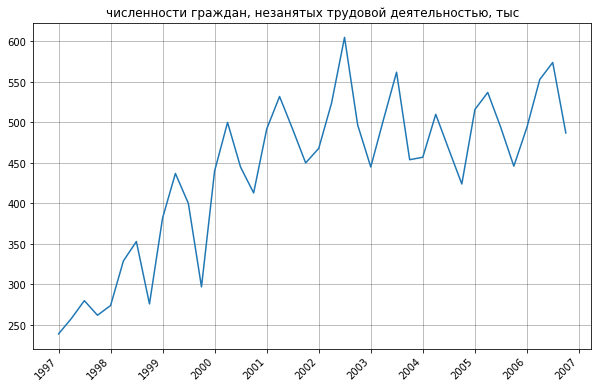

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(df[label]);
plt.xticks(rotation=45, ha="right");
plt.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.5);
plt.title(label=title);

## 2. Preprocessing

### 2.1 Тест на стационарность ряда

In [59]:
from statsmodels.tsa.stattools import adfuller

In [60]:
print(" > Is the data stationary ?")
dftest = adfuller(df[label], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {}stationary with {}% confidence"\
          .format(k, v, "not " if v<dftest[0] else "", 100-int(k[:-1])))


 > Is the data stationary ?
Test statistic = -2.173
P-value = 0.216
Critical values :
	1%: -3.6461350877925254 - The data is not stationary with 99% confidence
	5%: -2.954126991123355 - The data is not stationary with 95% confidence
	10%: -2.6159676124885216 - The data is not stationary with 90% confidence


Т.к. ряд нестационарный, необходимо провести преобразования.

### 2.2 Удаление тренда (detrend)

In [61]:
import statsmodels.api as sm

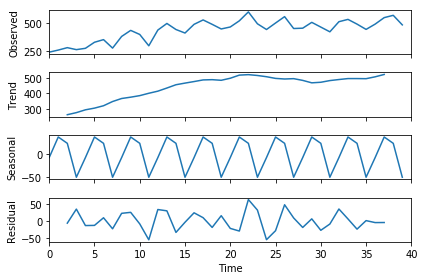

In [62]:
freq=4 #кол-во измерений за период (т.е. у нас это 4 измерения за год)

decomposition = sm.tsa.seasonal_decompose(df[label].values, freq=freq, model = 'additive')
resplot = decomposition.plot()

In [63]:
#массив, содержащий тренд
trend = decomposition.trend
#массив, содержащий сезонность
seasonal = decomposition.seasonal
#массив, содержащий остатки (ряд - тренд - сезонность) - как раз то, что нам надо
resid = decomposition.resid

#исходные данные при удалении одного только тренда
detrended_with_decomp = df[label].values - trend
#исходные данные при удалении тренда и сезонности
df['resid_sm'] = resid

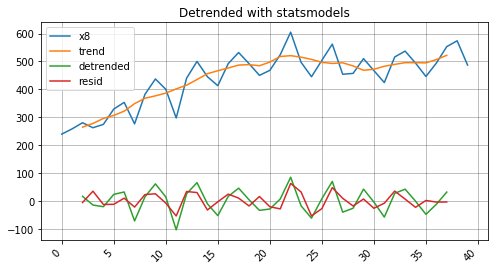

In [64]:
plt.figure(figsize=(8, 4))
plt.plot(df[label].values, label=label); #исходные данные
plt.plot(trend, label='trend'); #тренд
plt.plot(detrended_with_decomp, label='detrended'); #исходные данные минус тренд (но осталась сезонность, если она есть)
plt.plot(resid, label='resid'); #остатки = исходные данные минус тренд минус сезонность
plt.xticks(rotation=45, ha="right");
plt.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.5);
plt.legend();
plt.title('Detrended with statsmodels');

### 2.3 Заполнение пропусков (Nan)

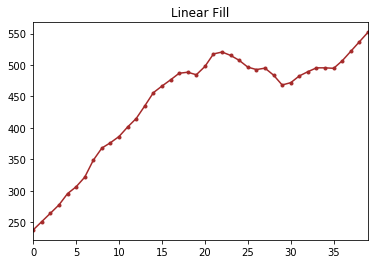

In [65]:
#заполним пустые значения в тренде
trend = pd.DataFrame(trend, columns=['trend'])
trend['rownum'] = np.arange(trend.shape[0])
df_nona = trend.dropna(subset = ['trend'])
f = interp1d(df_nona['rownum'], df_nona['trend'], fill_value="extrapolate")
trend['linear_fill'] = f(trend['rownum'])
trend['linear_fill'].plot(title="Linear Fill", label='Linear Fill', color='brown', style=".-");

Для заполнения пропуска в данных будем использовать метод ближайших соседей

In [66]:
#Mean of K-Nearest Neighbors ------
def knn_mean(ts, k):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            k_by_2 = np.ceil(k/2)
            lower = np.max([0, int(i-k_by_2)])
            upper = np.min([len(ts)+1, int(i+k_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

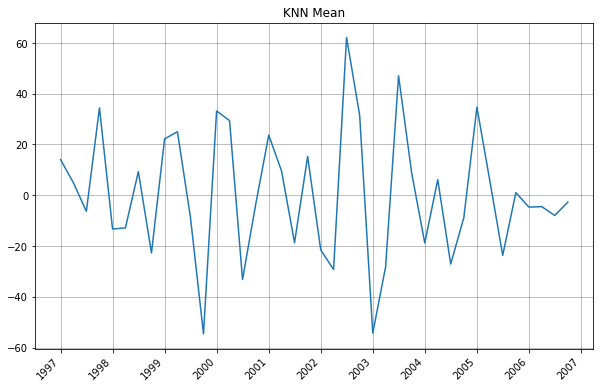

In [67]:
#заполняем пропуски в столбце col
col = 'resid_sm'
k = 8 #число соседей, которое используем для сглаживания

df['knn_mean'] = knn_mean(df[col].values, k)
df['trend'] = trend['linear_fill'].values
df['seasonal'] = seasonal

plt.figure(figsize=(10, 6))
plt.plot(df['knn_mean']);
plt.xticks(rotation=45, ha="right");
plt.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.5);
plt.title('KNN Mean');

In [68]:
#видим, что Nan в столбце resid_sm не осталось
df.head()

,x8,resid_sm,knn_mean,trend,seasonal
quarter_date,,,,,
1997-01-01,239.0,NaN,14.031250,237.625,-8.059028
1997-04-01,258.0,NaN,4.915509,250.875,35.621528
1997-07-01,280.0,-6.329861,-6.329861,264.125,22.204861
1997-10-01,262.0,34.392361,34.392361,277.375,-49.767361
1998-01-01,274.0,-13.315972,-13.315972,295.375,-8.059028


### 2.3 Повторная проверка на стационарность

In [69]:
col = 'knn_mean'

print(" > Is the data stationary ?")
dftest = adfuller(df[col].dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {}stationary with {}% confidence"
          .format(k, v, "not " if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Test statistic = -1.118
P-value = 0.708
Critical values :
	1%: -3.661428725118324 - The data is not stationary with 99% confidence
	5%: -2.960525341210433 - The data is not stationary with 95% confidence
	10%: -2.6193188033298647 - The data is not stationary with 90% confidence


Теперь ряд стационарный и с ним можно работать дальше. 
Но для данных с явно выраженной сезонностью ниже приведен пример избавления от нее. 

## 3. Train

В этом разделе будут обучаться модель многослойного перцептрона (MLP) и рекуррентной нейронной сети LSTM.

### 3.1. Делим на train и test

In [70]:
col = 'knn_mean' #данные, которые будем использовать в моделя для обучения и предсказания
new_df = df[[col]]

In [71]:
#дата, по которй делим на train и test
split_date = pd.Timestamp('2005-01-01')
#номер строки, оответствующий этой дате
split_index = len(new_df.loc[:split_date,:])-1 

In [72]:
print(col)
print(f'split_date: {split_date}')
print(f'length of dataset: {new_df.shape[0]}')
print(f'train_size: {split_index}')
print(f'test_size: {new_df.shape[0] - split_index}') 
print()

knn_mean
split_date: 2005-01-01 00:00:00
length of dataset: 40
train_size: 32
test_size: 8



In [73]:
#выделим train 
train = new_df.iloc[:split_index,]

### 3.2. Масштабируем

In [74]:
#создаем объект scaler класса MinMaxScaler 
scaler = MinMaxScaler(feature_range=(-1, 1))
#передаем в метод fit данные из train (только train, т.к. test - данные, которые мы предсказываем, то есть они из будущего, то есть "видеть" мы их на момент обучения модели как бы не можем)
scaler = scaler.fit(train)

In [75]:
#масштабируем весь столбец col ('knn_mean')
data = new_df[['knn_mean']].values
data = data.reshape(data.shape[0], data.shape[1])
df_scaled = scaler.transform(data)

#отдельно масштабируем train
train_scaled = scaler.transform(train)

### 3.3. Формируем обучающую матрицу

Теперь нам надо на основе Wi и Wo сформировать обучающую матрицу (X_train) и значения желаемых предсказаний (y_train)

In [76]:
#функция, которая преобразует ряд в обучающую матрицу 
def get_matrix_for_predict(data_sc, Wi, Wo):
    #data_sc - отмасштабируемые данные, которые хотим подать на вход в модель
    data_sc_df = pd.DataFrame(data_sc, columns=['Y'])
    
    #чтобы понять, что ту происходить, советую сделать пошагово на конкретном примере
    #в двух словах - сдвигаем столбец Y на одно значение вниз Wi+Wo раз
    data_sc_df['X_0'] = data_sc_df['Y']
    for s in range(1, Wi+Wo):
        data_sc_df['X_{}'.format(s)] = data_sc_df['Y'].shift(s)
    
    #делаем реверс колонок, чтобы данные в историческом порядке шли
    data_sc_df = data_sc_df.dropna().drop('Y', axis=1).iloc[:, ::-1] 
    
    X = data_sc_df.iloc[:, :Wi]
    y = data_sc_df.iloc[:, Wi:]
    
    X = X.as_matrix()
    y = y.as_matrix()
    
    return X, y

In [77]:
Wi=2 #число объектов на входе (признаки)
Wo=1 #число объектов на выходе (предсказания)
X_train, y_train = get_matrix_for_predict(data_sc=train_scaled, Wi=Wi, Wo=Wo)

In [78]:
#df_scaled - наши отмасштабированные исходные данные (все 40 штук объектов)
#split_index - индекс, по которому делили на train и test

#split_index-Wi, т.к. хотим предсказать для всех 4 значений теста 
#(а т.к. есть сдви по окну Wi, то для первых двух объектов предсказания не получим, если не зацепим Wi объектов из train
test = df_scaled[split_index-Wi:] 
len(test)

10

In [79]:
X_test, y_test = get_matrix_for_predict(data_sc=test, Wi=Wi, Wo=Wo)

In [80]:
#пути до папок, куда будем сохранять обученные модели
directory_1 = './models'
directory_2 = directory_1 + '/mlp'
directory_3 = directory_1 + '/lstm'

directories = [directory_1, directory_2, directory_3]

#cоздаем папки
for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)

### 3.4 MLP

In [81]:
#данные на вход модели MLP
X_train_mlp = X_train
y_train_mlp = y_train.ravel()

In [82]:
mlp_model = Sequential()

mlp_model.add(Dense(12, input_dim=Wi, activation='relu'))
mlp_model.add(Dense(Wo))
mlp_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = mlp_model.fit(X_train_mlp, y_train_mlp, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], 
                       shuffle=False)

mlp_model.save(f'{directory_2}/model_baseline', include_optimizer=True)

Epoch 1/100
30/30 [==============================] - 1s 17ms/step - loss: 0.1759
Epoch 2/100
30/30 [==============================] - 0s 1ms/step - loss: 0.1526
Epoch 3/100
30/30 [==============================] - 0s 1ms/step - loss: 0.1388
Epoch 4/100
30/30 [==============================] - 0s 1ms/step - loss: 0.1307
Epoch 5/100
30/30 [==============================] - 0s 1ms/step - loss: 0.1257
Epoch 6/100
30/30 [==============================] - 0s 1ms/step - loss: 0.1221
Epoch 7/100
30/30 [==============================] - 0s 1ms/step - loss: 0.1195
Epoch 8/100
30/30 [==============================] - 0s 1ms/step - loss: 0.1174
Epoch 9/100
30/30 [==============================] - 0s 1ms/step - loss: 0.1158
Epoch 10/100
30/30 [==============================] - 0s 1ms/step - loss: 0.1140
Epoch 11/100
30/30 [==============================] - 0s 1ms/step - loss: 0.1127
Epoch 12/100
30/30 [==============================] - 0s 1ms/step - loss: 0.1117
Epoch 13/100
30/30 [================

### MLP Predict

In [83]:
#данные на вход модели MLP
X_test_mlp = X_test
y_test_mlp = y_test.ravel()

In [84]:
first_mlp_y_pred_train = mlp_model.predict(X_train_mlp)
first_mlp_y_pred_test  = mlp_model.predict(X_test_mlp)

In [85]:
# invert predictions
first_mlp_trainPredict = scaler.inverse_transform(first_mlp_y_pred_train)
trainY = scaler.inverse_transform([y_train_mlp])

first_mlp_testPredict = scaler.inverse_transform(first_mlp_y_pred_test)
testY = scaler.inverse_transform([y_test_mlp])

In [141]:
print(first_mlp_y_pred_train)

[[-0.23560041]
 [-0.01193482]
 [-0.06536117]
 [-0.59348595]
 [ 0.20504168]
 [-0.06308706]
 [-0.00619069]
 [ 0.03494977]
 [-0.3009522 ]
 [-0.45082632]
 [ 0.5512074 ]
 [ 0.323694  ]
 [-0.45310488]
 [-0.3946779 ]
 [ 0.30703482]
 [-0.07577392]
 [-0.3901678 ]
 [-0.03932122]
 [-0.01698724]
 [-0.17411113]
 [ 0.46606037]
 [ 0.20743209]
 [-0.83962417]
 [-0.2975736 ]
 [ 0.8219883 ]
 [ 0.15334249]
 [-0.7477709 ]
 [-0.01854753]
 [ 0.02443212]
 [ 0.08558171]]


In [142]:
print(scaler.inverse_transform(first_mlp_y_pred_train))

[[-9.9751968e+00]
 [ 3.0843890e+00]
 [-3.5116207e-02]
 [-3.0871737e+01]
 [ 1.5753407e+01]
 [ 9.7666599e-02]
 [ 3.4197822e+00]
 [ 5.8219285e+00]
 [-1.3791015e+01]
 [-2.2541998e+01]
 [ 3.5965637e+01]
 [ 2.2681383e+01]
 [-2.2675039e+01]
 [-1.9263554e+01]
 [ 2.1708672e+01]
 [-6.4310485e-01]
 [-1.9000214e+01]
 [ 1.4853275e+00]
 [ 2.7893841e+00]
 [-6.3849053e+00]
 [ 3.0993998e+01]
 [ 1.5892980e+01]
 [-4.5243473e+01]
 [-1.3593742e+01]
 [ 5.1776230e+01]
 [ 1.2734747e+01]
 [-3.9880264e+01]
 [ 2.6982801e+00]
 [ 5.2078142e+00]
 [ 8.7782707e+00]]


In [86]:
# calculate root mean squared error
first_mlp_trainScore = math.sqrt(mean_squared_error(trainY[0], first_mlp_trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (first_mlp_trainScore))
first_mlp_testScore = math.sqrt(mean_squared_error(testY[0], first_mlp_testPredict[:,0]))
print('Test Score: %.2f RMSE' % (first_mlp_testScore))

Train Score: 17.33 RMSE
Test Score: 11.07 RMSE


### 3.5 LSTM

In [87]:
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train_lstm = y_train

In [88]:
# create and fit the LSTM network
lstm_model = Sequential()
lstm_model.add(LSTM(7, input_shape=(Wi, 1)))
lstm_model.add(Dense(Wo))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=1, verbose=2);

lstm_model.save(f'{directory_3}/model_baseline', include_optimizer=True)

Epoch 1/100
 - 1s - loss: 0.2221
Epoch 2/100
 - 0s - loss: 0.2176
Epoch 3/100
 - 0s - loss: 0.2123
Epoch 4/100
 - 0s - loss: 0.2067
Epoch 5/100
 - 0s - loss: 0.2019
Epoch 6/100
 - 0s - loss: 0.1964
Epoch 7/100
 - 0s - loss: 0.1914
Epoch 8/100
 - 0s - loss: 0.1857
Epoch 9/100
 - 0s - loss: 0.1799
Epoch 10/100
 - 0s - loss: 0.1743
Epoch 11/100
 - 0s - loss: 0.1681
Epoch 12/100
 - 0s - loss: 0.1615
Epoch 13/100
 - 0s - loss: 0.1557
Epoch 14/100
 - 0s - loss: 0.1511
Epoch 15/100
 - 0s - loss: 0.1463
Epoch 16/100
 - 0s - loss: 0.1400
Epoch 17/100
 - 0s - loss: 0.1365
Epoch 18/100
 - 0s - loss: 0.1319
Epoch 19/100
 - 0s - loss: 0.1296
Epoch 20/100
 - 0s - loss: 0.1264
Epoch 21/100
 - 0s - loss: 0.1255
Epoch 22/100
 - 0s - loss: 0.1244
Epoch 23/100
 - 0s - loss: 0.1219
Epoch 24/100
 - 0s - loss: 0.1215
Epoch 25/100
 - 0s - loss: 0.1196
Epoch 26/100
 - 0s - loss: 0.1194
Epoch 27/100
 - 0s - loss: 0.1206
Epoch 28/100
 - 0s - loss: 0.1194
Epoch 29/100
 - 0s - loss: 0.1187
Epoch 30/100
 - 0s - lo

### LSTM Predict

In [89]:
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test_lstm = y_test

In [90]:
# make predictions
first_lstm_y_pred_train = lstm_model.predict(X_train_lstm)
first_lstm_y_pred_test  = lstm_model.predict(X_test_lstm)

In [91]:
# invert predictions
first_lstm_trainPredict = scaler.inverse_transform(first_lstm_y_pred_train)
trainY = scaler.inverse_transform([y_train_lstm.ravel()])

first_lstm_testPredict = scaler.inverse_transform(first_lstm_y_pred_test)
testY = scaler.inverse_transform([y_test_lstm.ravel()])

In [92]:
# calculate root mean squared error
first_lstm_trainScore = math.sqrt(mean_squared_error(trainY[0], first_lstm_trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (first_lstm_trainScore))
first_lstm_testScore = math.sqrt(mean_squared_error(testY[0], first_lstm_testPredict[:,0]))
print('Test Score: %.2f RMSE' % (first_lstm_testScore))

Train Score: 19.59 RMSE
Test Score: 11.06 RMSE


### 3.6 Compare models

**Замечание**

Если W1 задавали больше 1, то эта визуализация не сработает по понятным причинам. <br>
Надо подумать, что делать с предсказанием на 2 и более значений. Мб усреднять.


In [93]:
#добавляем к данным обратно тренд и сезонность, чтобы можно было визуально сравнить качество предсказания

In [94]:
df.head()

,x8,resid_sm,knn_mean,trend,seasonal
quarter_date,,,,,
1997-01-01,239.0,NaN,14.031250,237.625,-8.059028
1997-04-01,258.0,NaN,4.915509,250.875,35.621528
1997-07-01,280.0,-6.329861,-6.329861,264.125,22.204861
1997-10-01,262.0,34.392361,34.392361,277.375,-49.767361
1998-01-01,274.0,-13.315972,-13.315972,295.375,-8.059028


In [95]:
trainY = trainY.ravel()
testY = testY.ravel()

first_mlp_trainPredict = first_mlp_trainPredict.ravel()
first_mlp_testPredict = first_mlp_testPredict.ravel()

first_lstm_trainPredict = first_lstm_trainPredict.ravel()
first_lstm_testPredict = first_lstm_testPredict.ravel()

#тренд
train_trend = df['trend'].values[Wi:split_index]
test_trend = df['trend'].values[split_index:]

#сезонность
train_seasonal = df['seasonal'].values[Wi:split_index]
test_seasonal = df['seasonal'].values[split_index:]

In [96]:
#добавляем обратно тренд и сезоность к каждому из предсказаний
first_mlp_trainPredict = first_mlp_trainPredict + train_trend + train_seasonal
first_mlp_testPredict = first_mlp_testPredict + test_trend + test_seasonal

first_lstm_trainPredict = first_lstm_trainPredict + train_trend + train_seasonal
first_lstm_testPredict = first_lstm_testPredict + test_trend + test_seasonal

trainY = trainY + train_trend + train_seasonal
testY = testY  + test_trend + test_seasonal

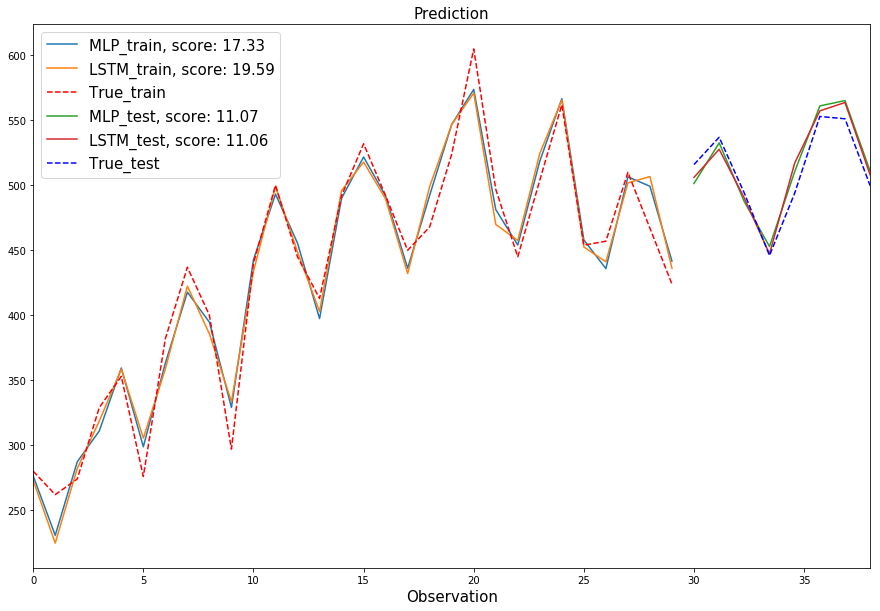

In [97]:
tr_len  = len(first_lstm_y_pred_train)
tst_len = len(first_lstm_y_pred_test)

plt.figure(figsize=(15, 10))

#предсказание MLP на train выборке
plt.plot(first_mlp_trainPredict, label=f'MLP_train, score: {first_mlp_trainScore:.2f}') 
#предсказание LSTM на train выборке
plt.plot(first_lstm_trainPredict, label=f'LSTM_train, score: {first_lstm_trainScore:.2f}')
#исходные данные
plt.plot(trainY, label='True_train', linestyle='--', color='r')
x = np.linspace(tr_len,tr_len+tst_len,tst_len)

#предсказание MLP на test выборке
plt.plot(x, first_mlp_testPredict, label=f'MLP_test, score: {first_mlp_testScore:.2f}')
#предсказание LSTM на test выборке
plt.plot(x, first_lstm_testPredict, label=f'LSTM_test, score: {first_lstm_testScore:.2f}')
#исходные данные
plt.plot(x, testY, label='True_test', linestyle='--', color='b')

plt.title("Prediction", fontsize=15)
plt.xlabel('Observation', fontsize=15)
plt.xlim((0,tr_len+tst_len))
plt.legend(fontsize=15)
plt.show();

In [98]:
a=((first_mlp_testPredict-testY)/testY)**2 
a=a.sum() 
b=((first_lstm_testPredict-testY)/testY)**2 
b=b.sum() 
c=(a/b)**0.5 
print('Статистика Тейла сравнения mlp и lstm',c)

Статистика Тейла сравнения mlp и lstm 0.9977313946811126


In [99]:
tmp_train = pd.DataFrame(trainY, columns=['x8'])
tmp_train['first_mlp_predict'] = first_mlp_trainPredict
tmp_train['first_lstm_predict'] = first_lstm_trainPredict

tmp_test = pd.DataFrame(testY, columns=['x8'])
tmp_test['first_mlp_predict'] = first_mlp_testPredict
tmp_test['first_lstm_predict'] = first_lstm_testPredict

In [100]:
predictions = pd.concat([tmp_train, tmp_test])
predictions['x8'] = round(predictions['x8'], 2)
df['x8'] = round(df['x8'], 2)

In [101]:
df_with_predictions = pd.merge(df, predictions, how='outer', on='x8')

In [102]:
df_with_predictions.head()

,x8,resid_sm,knn_mean,trend,seasonal,first_mlp_predict,first_lstm_predict
0,239.0,NaN,14.031250,237.625,-8.059028,NaN,NaN
1,258.0,NaN,4.915509,250.875,35.621528,NaN,NaN
2,280.0,-6.329861,-6.329861,264.125,22.204861,276.354664,272.996913
3,262.0,34.392361,34.392361,277.375,-49.767361,230.692028,224.703350
4,274.0,-13.315972,-13.315972,295.375,-8.059028,287.280856,282.211872


In [103]:
df_with_predictions.to_csv('compare_models.csv')

## 4. Train 5 models

In [104]:
#задаем словарь с различными значениями параметров сети (параметры можно любые указывать, я просто пример привожу)

params = {'num_of_hidden_layers' : [0, 1, 2],      #число скрытых слоев (если вдруг хотим несколько)
          'num_of_hidden_neurons': [2, 3, 7, 10, 15], #число скрытых нейронов на в слое (если хоти несколько слоев, то этот параметр будет для каждого слоя выбираться заново)
          'epochs': [50, 100, 200],         #число эпох
          'activation': ['relu', 'linear']       #функция активации (про linear не уверена, но вроде есть такая)
        }

In [105]:
def predict(X_train, y_train, X_test, y_test, model, model_type):
     
    # predict  
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)
    
    # invert predictions
    trainPredict = scaler.inverse_transform(y_pred_train)
    testPredict = scaler.inverse_transform(y_pred_test)
    if model_type=='MLP':
        trainY = scaler.inverse_transform([y_train])
        testY = scaler.inverse_transform([y_test])
    elif model_type=='LSTM':
        trainY = scaler.inverse_transform([y_train.ravel()])
        testY = scaler.inverse_transform([y_test.ravel()])
    
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    print()
    
    return trainPredict, testPredict, trainScore, testScore

In [106]:
def train_several_models(directory, X_train, y_train, X_test, y_test, Wi=2, Wo=1, model_type='MLP', n=5):
    
    #в этот словарь можно складывать полученные результаты работы всех пяти моделей(predict и параметры моделей)
    tmp_dict = {}
    
    for i in range(n):
        #инициализировали модель
        model = Sequential()
        #словарь, в который будем параметры складывать
        tmp_params = {}
        
        #выбираем рандомные параметры для первого слоя
        num_of_hid_neur_0 = random.choice(params['num_of_hidden_neurons']) 
        activation_0 = random.choice(params['activation']) 
        
        #записываем параметры в словарь
        tmp_params['num_of_hid_neur_0'] = num_of_hid_neur_0
        tmp_params['activation_0'] = activation_0
        
        #добавляем первый слой с выбранными выше параметрами (первый слой будет разным для MLP и LSTM)
        if model_type=='MLP':
            model.add(Dense(num_of_hid_neur_0, input_dim=Wi, activation=activation_0))
        elif model_type=='LSTM':
            model.add(LSTM(num_of_hid_neur_0, input_shape=(Wi, 1), activation=activation_0))
        
        #выбираем число скрытых слоев
        num_of_hidden_layers = random.choice(params['num_of_hidden_layers']) 
        #добавляем число слоев в словарь
        tmp_params['num_of_hidden_layers'] = num_of_hidden_layers
        
        #создаем столько скрытых слоев, сколько выбрали в num_of_hidden_layers
        for j in range(0, num_of_hidden_layers):
            #выбираем рандомные параметры для этого слоя
            num_of_hid_neur_j = random.choice(params['num_of_hidden_neurons'])
            activation_j = random.choice(params['activation']) 
            #добавляем параметры слоя в словарь
            tmp_params[f'num_of_hid_neur_{j+1}'] = num_of_hid_neur_j
            tmp_params[f'activation_{j+1}'] = activation_j
            #добавляем сам слой
            model.add(Dense(num_of_hid_neur_j, activation=activation_j)) #тут j - просто часть имени, а не параметр
        
        #задаем выходной слой
        activation_out = random.choice(params['activation']) 
        tmp_params['activation_out'] = activation_out
        
        model.add(Dense(Wo, activation=activation_out))
        
        #compile
        model.compile(loss='mean_squared_error', optimizer='adam')
        early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)

        epochs = random.choice(params['epochs']) 
        tmp_params['epochs'] = epochs

        print(f'start training model {i}')
        print(f'params: {tmp_params}')
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=1, 
                                verbose=1, callbacks=[early_stop], shuffle=False)
        
        
        #predict
        trainPredict, testPredict, trainScore, testScore = predict(X_train, y_train, X_test, y_test, 
                                                                   model, model_type)
        
        #дальше все собираем в словарь, чтобы потом из него можно было достать то, что нам надо (для лучше модели)
        tmp_dict[f'model_{i}'] = {'params': tmp_params, 
                                  'prediction': {'y_pred_train': trainPredict.ravel(), 
                                                 'y_pred_test': testPredict.ravel()},
                                  'train_score': trainScore,
                                  'test_score': testScore
                                 }

        #а теперь сохраняем полученную модель 
        model.save(f'{directory}/model_{i}', include_optimizer=True)
        
    return tmp_dict

### 4.1 Train models

In [107]:
#выше уже задавали, но на всякий случай повторим
X_train_mlp = X_train
y_train_mlp = y_train.ravel()
X_test_mlp  = X_test
y_test_mlp  = y_test.ravel()

X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train_lstm = y_train
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test_lstm = y_test

Wi = 2
Wo = 1

In [108]:
mlp_dict = train_several_models(directory=directory_2, 
                                X_train=X_train_mlp, 
                                y_train=y_train_mlp, 
                                X_test=X_test_mlp, 
                                y_test=y_test_mlp, 
                                Wi=2, Wo=1, 
                                model_type='MLP', 
                                n=5)

start training model 0
params: {'num_of_hid_neur_0': 3, 'activation_0': 'linear', 'num_of_hidden_layers': 1, 'num_of_hid_neur_1': 15, 'activation_1': 'relu', 'activation_out': 'relu', 'epochs': 200}
Epoch 1/200
30/30 [==============================] - 1s 26ms/step - loss: 0.2561
Epoch 2/200
30/30 [==============================] - 0s 2ms/step - loss: 0.2467
Epoch 3/200
30/30 [==============================] - 0s 2ms/step - loss: 0.2427
Epoch 4/200
30/30 [==============================] - 0s 2ms/step - loss: 0.2402
Epoch 5/200
30/30 [==============================] - 0s 2ms/step - loss: 0.2399
Epoch 6/200
30/30 [==============================] - 0s 2ms/step - loss: 0.2399
Epoch 7/200
30/30 [==============================] - 0s 1ms/step - loss: 0.2399
Epoch 00007: early stopping
Train Score: 28.60 RMSE
Test Score: 15.98 RMSE

start training model 1
params: {'num_of_hid_neur_0': 10, 'activation_0': 'relu', 'num_of_hidden_layers': 2, 'num_of_hid_neur_1': 2, 'activation_1': 'relu', 'num_of_

30/30 [==============================] - 0s 2ms/step - loss: 0.2285
Epoch 8/50
30/30 [==============================] - 0s 2ms/step - loss: 0.2275
Epoch 9/50
30/30 [==============================] - 0s 2ms/step - loss: 0.2260
Epoch 10/50
30/30 [==============================] - 0s 2ms/step - loss: 0.2249
Epoch 11/50
30/30 [==============================] - 0s 2ms/step - loss: 0.2235
Epoch 12/50
30/30 [==============================] - 0s 2ms/step - loss: 0.2220
Epoch 13/50
30/30 [==============================] - 0s 2ms/step - loss: 0.2206
Epoch 14/50
30/30 [==============================] - 0s 2ms/step - loss: 0.2192
Epoch 15/50
30/30 [==============================] - 0s 2ms/step - loss: 0.2175
Epoch 16/50
30/30 [==============================] - 0s 1ms/step - loss: 0.2160
Epoch 17/50
30/30 [==============================] - 0s 1ms/step - loss: 0.2144
Epoch 18/50
30/30 [==============================] - 0s 1ms/step - loss: 0.2128
Epoch 19/50
30/30 [==============================] - 0

30/30 [==============================] - 0s 1ms/step - loss: 0.1150
Epoch 57/100
30/30 [==============================] - 0s 2ms/step - loss: 0.1150
Epoch 58/100
30/30 [==============================] - 0s 2ms/step - loss: 0.1150
Epoch 59/100
30/30 [==============================] - 0s 2ms/step - loss: 0.1150
Epoch 60/100
30/30 [==============================] - 0s 2ms/step - loss: 0.1150
Epoch 61/100
30/30 [==============================] - 0s 2ms/step - loss: 0.1150
Epoch 62/100
30/30 [==============================] - 0s 2ms/step - loss: 0.1150
Epoch 63/100
30/30 [==============================] - 0s 2ms/step - loss: 0.1150
Epoch 64/100
30/30 [==============================] - 0s 2ms/step - loss: 0.1150
Epoch 65/100
30/30 [==============================] - 0s 2ms/step - loss: 0.1150
Epoch 66/100
30/30 [==============================] - 0s 2ms/step - loss: 0.1150
Epoch 67/100
30/30 [==============================] - 0s 2ms/step - loss: 0.1150
Epoch 68/100
30/30 [=====================

In [109]:
lstm_dict = train_several_models(directory=directory_3, 
                                X_train=X_train_lstm, 
                                y_train=y_train_lstm, 
                                X_test=X_test_lstm, 
                                y_test=y_test_lstm, 
                                Wi=2, Wo=1, 
                                model_type='LSTM', 
                                n=5)

start training model 0
params: {'num_of_hid_neur_0': 10, 'activation_0': 'relu', 'num_of_hidden_layers': 1, 'num_of_hid_neur_1': 15, 'activation_1': 'relu', 'activation_out': 'relu', 'epochs': 200}
Epoch 1/200
30/30 [==============================] - 2s 69ms/step - loss: 0.2399
Epoch 2/200
30/30 [==============================] - 0s 3ms/step - loss: 0.2399
Epoch 3/200
30/30 [==============================] - 0s 4ms/step - loss: 0.2399
Epoch 00003: early stopping
Train Score: 28.60 RMSE
Test Score: 15.98 RMSE

start training model 1
params: {'num_of_hid_neur_0': 3, 'activation_0': 'relu', 'num_of_hidden_layers': 2, 'num_of_hid_neur_1': 15, 'activation_1': 'relu', 'num_of_hid_neur_2': 2, 'activation_2': 'linear', 'activation_out': 'relu', 'epochs': 100}
Epoch 1/100
30/30 [==============================] - 2s 73ms/step - loss: 0.2399
Epoch 2/100
30/30 [==============================] - 0s 5ms/step - loss: 0.2399
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.23

30/30 [==============================] - 0s 3ms/step - loss: 0.1887
Epoch 36/50
30/30 [==============================] - 0s 4ms/step - loss: 0.1876
Epoch 37/50
30/30 [==============================] - 0s 4ms/step - loss: 0.1865
Epoch 38/50
30/30 [==============================] - 0s 4ms/step - loss: 0.1853
Epoch 39/50
30/30 [==============================] - 0s 4ms/step - loss: 0.1842
Epoch 40/50
30/30 [==============================] - 0s 4ms/step - loss: 0.1833
Epoch 41/50
30/30 [==============================] - 0s 4ms/step - loss: 0.1827
Epoch 42/50
30/30 [==============================] - 0s 4ms/step - loss: 0.1819
Epoch 43/50
30/30 [==============================] - 0s 5ms/step - loss: 0.1810
Epoch 44/50
30/30 [==============================] - 0s 4ms/step - loss: 0.1808
Epoch 45/50
30/30 [==============================] - 0s 5ms/step - loss: 0.1802
Epoch 46/50
30/30 [==============================] - 0s 4ms/step - loss: 0.1796
Epoch 47/50
30/30 [==============================] -

## 4.2 Параметры моделей

In [110]:
def print_params(tmp_dict):
    for model in tmp_dict:
        params = tmp_dict[model]['params']
        train_score = tmp_dict[model]['train_score']
        test_score = tmp_dict[model]['test_score']

        print(f'{model} params: {params}')
        print(f'train score: {train_score}')
        print(f'test score: {test_score}')
        print()

In [111]:
#посмотрим на параметры обученных моделей MLP
print_params(mlp_dict)

model_0 params: {'num_of_hid_neur_0': 3, 'activation_0': 'linear', 'num_of_hidden_layers': 1, 'num_of_hid_neur_1': 15, 'activation_1': 'relu', 'activation_out': 'relu', 'epochs': 200}
train score: 28.599983003102952
test score: 15.981153987487147

model_1 params: {'num_of_hid_neur_0': 10, 'activation_0': 'relu', 'num_of_hidden_layers': 2, 'num_of_hid_neur_1': 2, 'activation_1': 'relu', 'num_of_hid_neur_2': 15, 'activation_2': 'relu', 'activation_out': 'linear', 'epochs': 100}
train score: 20.90330032087068
test score: 15.623752691919433

model_2 params: {'num_of_hid_neur_0': 3, 'activation_0': 'relu', 'num_of_hidden_layers': 2, 'num_of_hid_neur_1': 2, 'activation_1': 'relu', 'num_of_hid_neur_2': 7, 'activation_2': 'linear', 'activation_out': 'relu', 'epochs': 50}
train score: 25.14820390043601
test score: 13.951321248792667

model_3 params: {'num_of_hid_neur_0': 10, 'activation_0': 'linear', 'num_of_hidden_layers': 0, 'activation_out': 'linear', 'epochs': 100}
train score: 19.719165166

In [112]:
#посмотрим на параметры обученных моделей LSTM
print_params(lstm_dict)

model_0 params: {'num_of_hid_neur_0': 10, 'activation_0': 'relu', 'num_of_hidden_layers': 1, 'num_of_hid_neur_1': 15, 'activation_1': 'relu', 'activation_out': 'relu', 'epochs': 200}
train score: 28.599983003102952
test score: 15.981153987487147

model_1 params: {'num_of_hid_neur_0': 3, 'activation_0': 'relu', 'num_of_hidden_layers': 2, 'num_of_hid_neur_1': 15, 'activation_1': 'relu', 'num_of_hid_neur_2': 2, 'activation_2': 'linear', 'activation_out': 'relu', 'epochs': 100}
train score: 28.599983003102952
test score: 15.981153987487147

model_2 params: {'num_of_hid_neur_0': 7, 'activation_0': 'linear', 'num_of_hidden_layers': 0, 'activation_out': 'linear', 'epochs': 50}
train score: 19.489001656139358
test score: 11.017513964511831

model_3 params: {'num_of_hid_neur_0': 10, 'activation_0': 'relu', 'num_of_hidden_layers': 0, 'activation_out': 'relu', 'epochs': 50}
train score: 24.585023258797843
test score: 13.920359049444382

model_4 params: {'num_of_hid_neur_0': 15, 'activation_0': 'r

In [113]:
def best_score(tmp_dict):
    scores = []
    for i in tmp_dict:
        train_score = tmp_dict[i]['train_score']
        test_score = tmp_dict[i]['test_score']
        scores.append((i, train_score, test_score))
    
    scores.sort(key=lambda tup: tup[2], reverse=True)  
    return scores[-2] #лучшая модель та, у которой ошибка меньше, но не самая последняя, она скорее всего переобученная

In [114]:
best_score_mlp = best_score(mlp_dict)
print(f'MLP best_score: {best_score_mlp}') 

MLP best_score: ('model_2', 25.14820390043601, 13.951321248792667)


In [115]:
best_score_lstm = best_score(lstm_dict)
print(f'LSTM best_score: {best_score_lstm}') 

LSTM best_score: ('model_3', 24.585023258797843, 13.920359049444382)


## 4.3 Сравнение моделей

### Compare all models

In [116]:
def draw_models(tmp_dict, trainY, testY, model_type):
    tr_len = len(trainY)
    tst_len = len(testY)
    
    plt.figure(figsize=(15, 10))
    x = np.linspace(tr_len,tr_len+tst_len,tst_len)
    
    #исходные данные
    plt.plot(trainY, label='True_train', linestyle='--', color='r')
    plt.plot(x, testY, label='True_test', linestyle='--', color='b')
    
    for mod in tmp_dict:
        trainPredict = tmp_dict[mod]['prediction']['y_pred_train'].ravel() + train_trend + train_seasonal
        testPredict = tmp_dict[mod]['prediction']['y_pred_test'].ravel() + test_trend + test_seasonal
        
        trainScore = tmp_dict[mod]['train_score']
        testScore = tmp_dict[mod]['test_score']
        
        plt.plot(trainPredict, label=f'{model_type} {mod} train score: {trainScore:.2f}') 
        #предсказание на test выборке
        plt.plot(x, testPredict, label=f'{model_type} {mod} test, score: {testScore:.2f}')
    
    plt.title(f"{model_type} Prediction", fontsize=15)
    plt.xlabel('Observation', fontsize=15)
    plt.xlim((0,tr_len+tst_len))
    plt.legend(fontsize=15)
    plt.show();

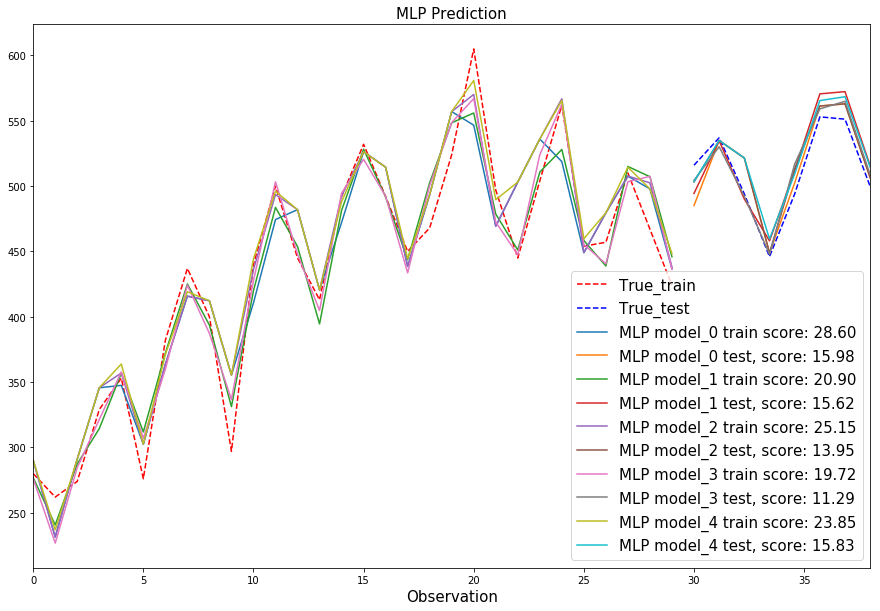

In [117]:
draw_models(mlp_dict, trainY, testY, model_type='MLP')

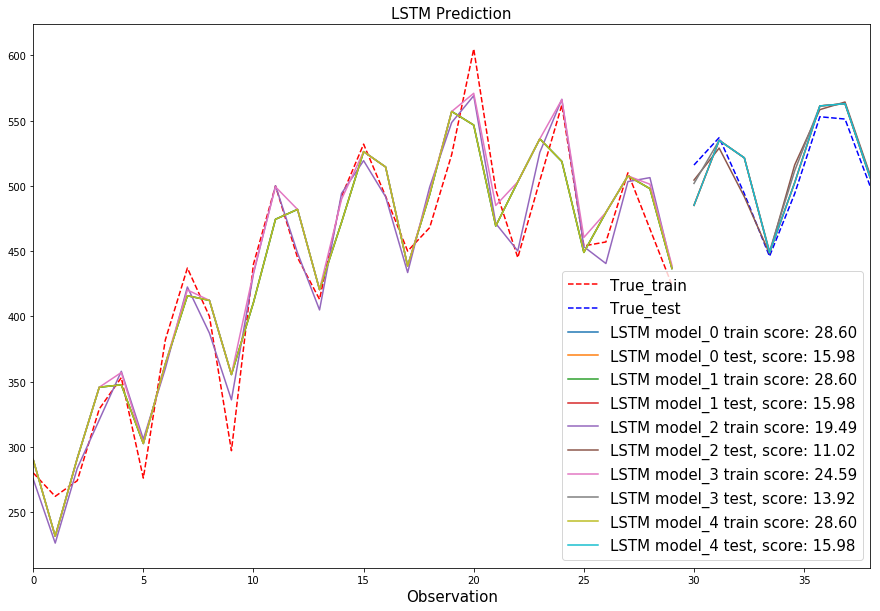

In [118]:
draw_models(lstm_dict, trainY, testY, model_type='LSTM')

### Best model

In [119]:
best_model_mlp_id  = best_score_mlp[0]
best_model_lstm_id = best_score_lstm[0]

In [120]:
best_mlp_trainPredict = mlp_dict[best_model_mlp_id]['prediction']['y_pred_train']
best_mlp_testPredict = mlp_dict[best_model_mlp_id]['prediction']['y_pred_test']

best_lstm_trainPredict = lstm_dict[best_model_lstm_id]['prediction']['y_pred_train']
best_lstm_testPredict = lstm_dict[best_model_lstm_id]['prediction']['y_pred_test']

In [121]:
#добавляем обратно тренд и сезоность к каждому из предсказаний
best_mlp_trainPredict = best_mlp_trainPredict.ravel() + train_trend + train_seasonal
best_mlp_testPredict = best_mlp_testPredict.ravel() + test_trend + test_seasonal

best_lstm_trainPredict = best_lstm_trainPredict.ravel() + train_trend + train_seasonal
best_lstm_testPredict = best_lstm_testPredict.ravel() + test_trend + test_seasonal

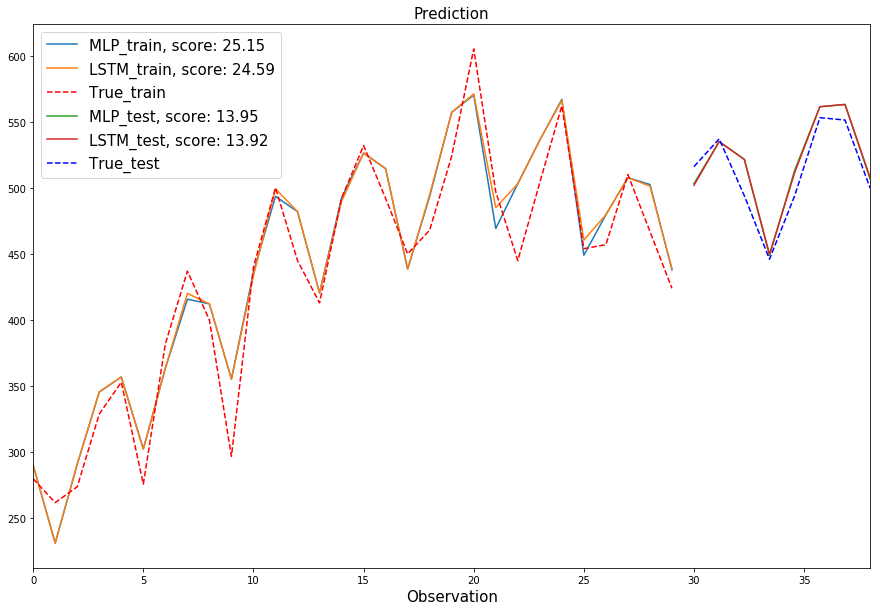

In [122]:
plt.figure(figsize=(15, 10))

#предсказание MLP на train выборке
plt.plot(best_mlp_trainPredict, label=f'MLP_train, score: {best_score_mlp[1]:.2f}') 
#предсказание LSTM на train выборке
plt.plot(best_lstm_trainPredict, label=f'LSTM_train, score: {best_score_lstm[1]:.2f}')
#исходные данные
plt.plot(trainY, label='True_train', linestyle='--', color='r')
x = np.linspace(tr_len,tr_len+tst_len,tst_len)

#предсказание MLP на test выборке
plt.plot(x, best_mlp_testPredict, label=f'MLP_test, score: {best_score_mlp[2]:.2f}')
#предсказание LSTM на test выборке
plt.plot(x, best_lstm_testPredict, label=f'LSTM_test, score: {best_score_lstm[2]:.2f}')
#исходные данные
plt.plot(x, testY, label='True_test', linestyle='--', color='b')

plt.title("Prediction", fontsize=15)
plt.xlabel('Observation', fontsize=15)
plt.xlim((0,tr_len+tst_len))
plt.legend(fontsize=15)
plt.show();

Ну и последний шаг: сравнить с тем, что мы получили без перебора параметров

In [123]:
print('Ошибки моделей ДО перебора параметров:')
print(f'MLP train score: {first_mlp_trainScore:.2f}')
print(f'MLP test score: {first_mlp_testScore:.2f}')
print(f'LSTM train score: {first_lstm_trainScore:.2f}')
print(f'LSTM test score: {first_lstm_testScore:.2f}')
print()
print('Ошибки моделей ПОСЛЕ перебора параметров:')
print(f'MLP train score: {best_score_mlp[1]:.2f}')
print(f'MLP test score: {best_score_mlp[2]:.2f}')
print(f'LSTM train score: {best_score_lstm[1]:.2f}')
print(f'LSTM test score: {best_score_lstm[2]:.2f}')

Ошибки моделей ДО перебора параметров:
MLP train score: 17.33
MLP test score: 11.07
LSTM train score: 19.59
LSTM test score: 11.06

Ошибки моделей ПОСЛЕ перебора параметров:
MLP train score: 25.15
MLP test score: 13.95
LSTM train score: 24.59
LSTM test score: 13.92


In [124]:
a=((best_mlp_testPredict-testY)/testY)**2 
a=a.sum() 
b=((best_lstm_testPredict-testY)/testY)**2 
b=b.sum() 
c=(a/b)**0.5 
print('Статистика Тейла сравнения mlp и lstm', c)

Статистика Тейла сравнения mlp и lstm 1.0029054367937886


## 5. Prediction for 10 periods

In [125]:
from keras.models import load_model

In [126]:
print(f'MLP best_score: {best_score_mlp}') 
print(f'LSTM best_score: {best_score_lstm}') 

MLP best_score: ('model_2', 25.14820390043601, 13.951321248792667)
LSTM best_score: ('model_3', 24.585023258797843, 13.920359049444382)


In [127]:
best_model_type = 'MLP'
best_model = 'model_baseline' 
#если хотим взять одну из двух самых первых моделей (которые были обучены без перебора параметров)
#то пишем best_model = 'model_baseline' 

In [128]:
if best_model_type=='MLP':
    path_to_best_model = directory_2 + f'/{best_model}'
elif best_model_type=='LSTM':
    path_to_best_model = directory_3 + f'/{best_model}'

print(path_to_best_model)

./models/mlp/model_baseline


In [129]:
best_model = load_model(path_to_best_model)

In [130]:
T = 10 #на сколько периодов вперед предсказываем

In [131]:
X_small = df_scaled[-(Wi+1):-1]

if best_model_type=='MLP':
    X_small = X_small.reshape(X_small.shape[1], X_small.shape[0])
elif best_model_type=='LSTM':
    X_small = X_small.reshape(X_small.shape[1], X_small.shape[0], 1)

In [132]:
predictions = []
for t in range(T+1):
    
    #print(X_small)
    prediction_t = best_model.predict(X_small)
    
    if best_model_type=='MLP':
        X_small = np.array([X_small[0][-1] , prediction_t[0][0]])
        X_small = X_small.reshape(1, X_small.shape[0])
        #X_small = X_small.reshape(1, X_small.shape[0])
        predictions.append(prediction_t[0][0])
        
    elif best_model_type=='LSTM':
        X_small = np.array([X_small[0][-1][0] , prediction_t[0][0]])
        X_small = X_small.reshape(1, X_small.shape[0], 1)
        predictions.append(prediction_t[0][0])
    
    
#почему тут такие индексы и решейпы - не спрашивайте, я сама запуталась. главное, что работает

In [133]:
predictions_sc = scaler.inverse_transform([predictions])

In [134]:
predictions_df = pd.DataFrame(predictions_sc.reshape(len(predictions_sc[0]),1), columns=['prediction'])
predictions_df['rownum'] = np.arange(df.shape[0]-1, df.shape[0] + predictions_df.shape[0]-1)

In [135]:
df['rownum'] = np.arange(df.shape[0])
f1 = interp1d(df['rownum'], df['trend'], fill_value="extrapolate")
f2 = interp1d(df['rownum'], df['seasonal'], fill_value="extrapolate")

In [136]:
predictions_df['trend'] = f1(predictions_df['rownum'])
predictions_df['seasonal'] = f2(predictions_df['rownum'])
predictions_df['result'] = predictions_df['prediction'] + predictions_df['trend'] #+ predictions_df['seasonal'] 
predictions_df = predictions_df.set_index('rownum')

In [137]:
predictions_df

,prediction,trend,seasonal,result
rownum,,,,
39,8.392415,552.125,-49.767361,560.517415
40,-0.680560,567.250,-121.739583,566.569440
41,-3.936348,582.375,-193.711806,578.438652
42,3.852579,597.500,-265.684028,601.352579
43,-0.235350,612.625,-337.656250,612.389650
44,-0.779357,627.750,-409.628472,626.970643
45,1.418239,642.875,-481.600694,644.293239
46,0.099844,658.000,-553.572917,658.099844
47,0.066486,673.125,-625.545139,673.191486


In [138]:
df = df.reset_index(drop=True)
fin = df.join(predictions_df, how='outer', rsuffix='_r')

In [139]:
rng = pd.date_range(start='1997-01-01 00:00:00', periods=df.shape[0]+predictions_df.shape[0]-1, freq='3M')
fin = fin.set_index(rng)

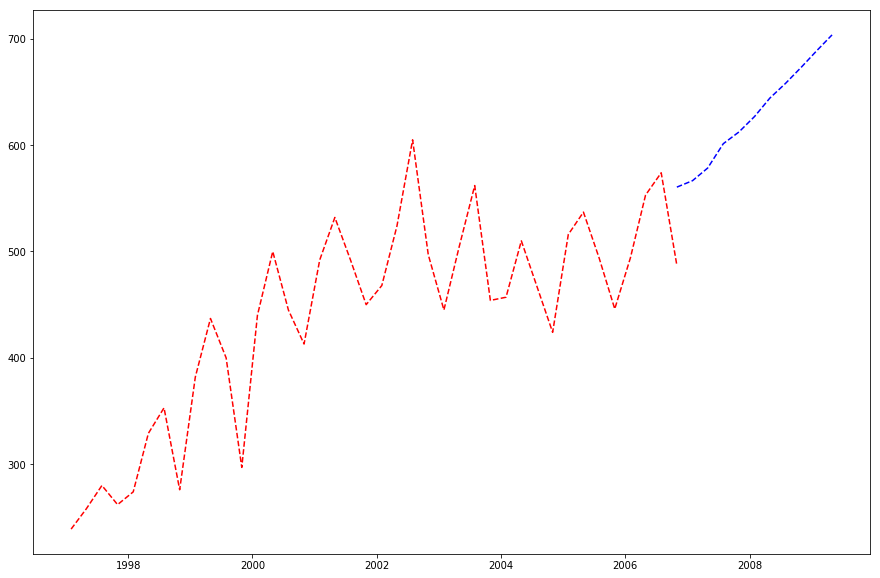

In [140]:
plt.figure(figsize=(15, 10))

plt.plot(fin[[label]], label='True_train', linestyle='--', color='r');
plt.plot(fin[['result']], label='True_train', linestyle='--', color='b');
#plt.plot(fin[['trend', 'trend_r']], label='True_train', linestyle='--', color='g');